In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO)

## Load Data

In [3]:
epoch_key = ('jaq', 1, 2) # animal, day, epoch

In [4]:
from src.load_data import load_data

data = load_data(epoch_key)

INFO:src.load_data:Loading position information and linearizing...
INFO:src.load_data:Loading multiunits...


Data is a dictionary with two keys: `position_info` and `multiunits`.

Position info has 1D and 2D position data as well as head direction and speed. Multiunits has the marks.

These are both interpolated to/binned at 500 Hz.

In [5]:
data['position_info']

,x_position,y_position,head_direction,speed,linear_distance,track_segment_id,linear_position
time,,,,,,,
00:43:30.546587,28.574616,50.447565,-0.524582,27.167580,55.166435,0.0,241.577308
00:43:30.548587,28.620635,50.416210,-0.522722,27.038446,55.111752,0.0,241.522625
00:43:30.550587,28.666655,50.384854,-0.520861,26.909312,55.057070,0.0,241.467942
00:43:30.552587,28.712674,50.353498,-0.519001,26.780177,55.002387,0.0,241.413260
00:43:30.554587,28.758693,50.322143,-0.517140,26.651043,54.947704,0.0,241.358577
...,...,...,...,...,...,...,...
01:17:35.746587,4.403802,28.534400,-2.917781,2.868040,34.784349,5.0,52.699586
01:17:35.748587,4.405093,28.526955,-2.910619,2.929845,34.782839,5.0,52.698076
01:17:35.750587,4.406384,28.519511,-2.903458,2.991649,34.781329,5.0,52.696566


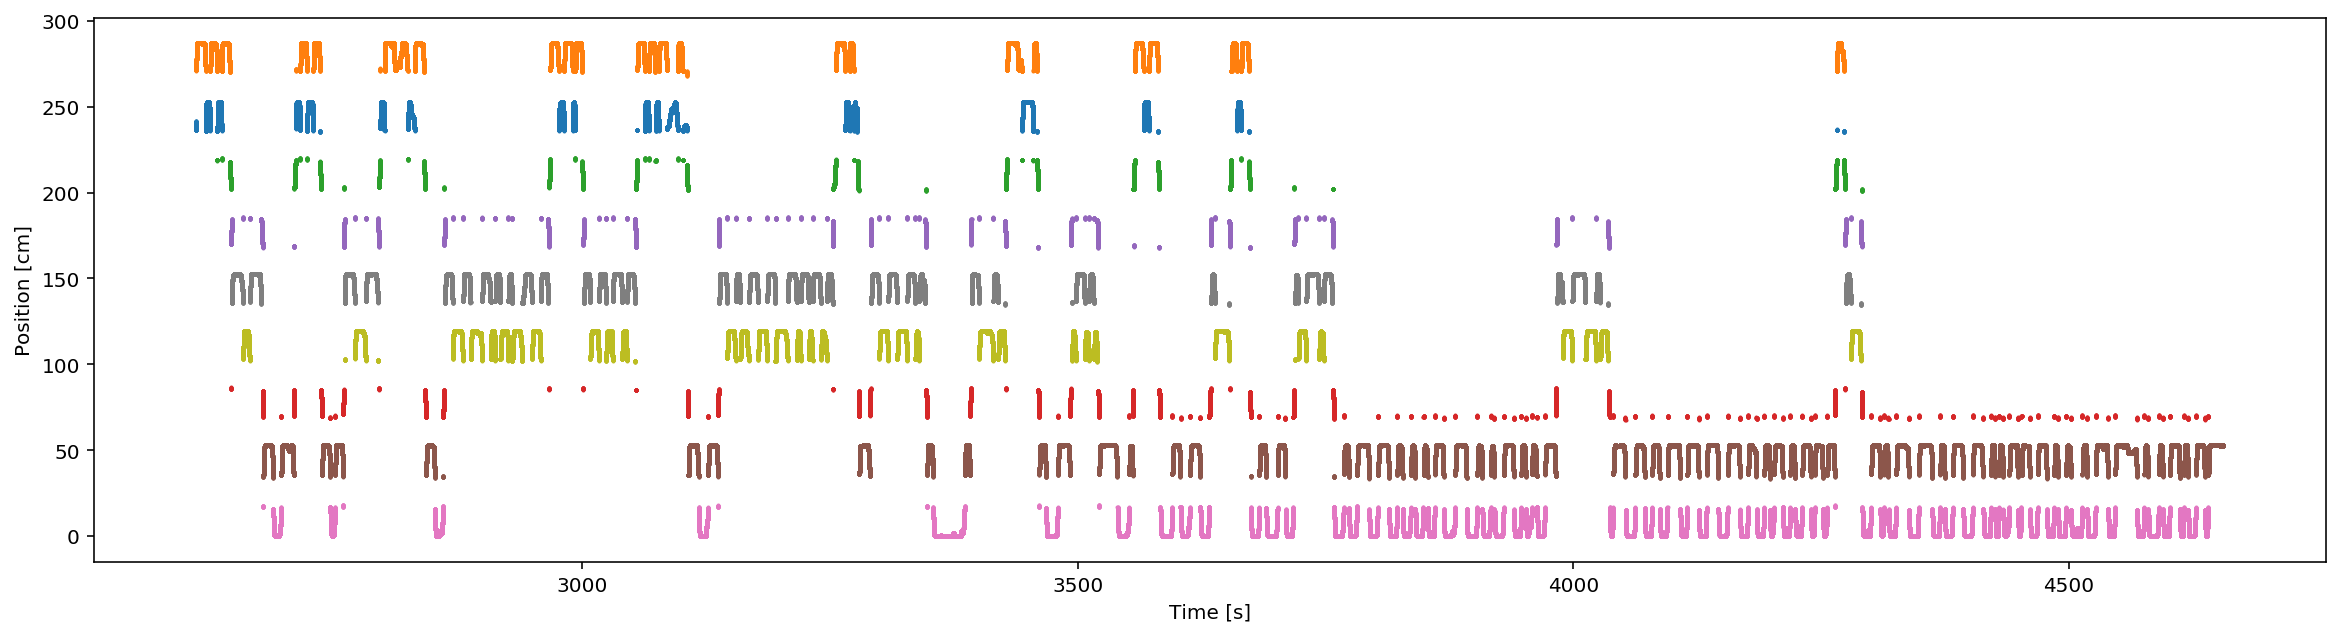

In [29]:
fig, ax = plt.subplots(figsize=(20, 5))

for edge_label, df in data['position_info'].groupby('track_segment_id'):
    ax.scatter(df.index / np.timedelta64(1, 's'), df.linear_position, s=1)
    
ax.set_ylabel('Position [cm]')
ax.set_xlabel('Time [s]');

In [6]:
data['multiunits']

<xarray.DataArray (time: 1022605, features: 4, tetrodes: 27)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[ nan,  33.,  nan, ...,  nan, 187.,  nan],
        [ nan,  71.,  nan, ...,  nan,  -2.,  nan],
        [ nan,  19.,  nan, ...,  nan,  58.,  nan],
        [ nan,  29.,  nan, ...,  nan,  48.,  nan]],

       [[ nan,  51.,  nan, ...,  nan,  47.,  nan],
        [ nan, 624.,  nan, ...,  nan,  33.,  nan],
        [ nan,  18.,  nan, ...,  nan,  62.,  nan],
        [ nan,  95.,  nan, ...,  nan,  48.,  nan]],

       ...,

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],

In [31]:
data['multiunits'].isel(tetrodes=0).dropna('time')

<xarray.DataArray (time: 146536, features: 4)>
array([[ 47.,  53.,  27.,  63.],
       [140.,  -4.,  37.,  27.],
       [109.,  -4.,  33.,  30.],
       ...,
       [ 60.,  52.,  31.,  34.],
       [ 80.,  63.,  59.,  72.],
       [ 49.,  31.,  21.,  66.]])
Coordinates:
  * time      (time) timedelta64[ns] 00:43:30.564587 ... 01:17:35.748587
  * features  (features) <U13 'channel_1_max' ... 'channel_4_max'

## Fitting the decoder

Dask is used to parallelize the clusterless decode. In this case we are only using one worker, but we could use more to speed up the decoding.

In [7]:
from dask.distributed import Client

client = Client(n_workers=1,
                threads_per_worker=1,
                processes=True,
                memory_limit='25GB')

Next we import the decoder and set the parameters for decoding. We use the help (?) to tell use what the parameters are.

In [27]:
from replay_trajectory_classification import ClusterlessDecoder

ClusterlessDecoder?

Init signature:
ClusterlessDecoder(
    place_bin_size=2.0,
    replay_speed=40,
    movement_var=0.05,
    position_range=None,
    model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
    model_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.,  6.])},
    occupancy_model=None,
    occupancy_kwargs=None,
    transition_type='random_walk',
    initial_conditions_type='uniform_on_track',
    infer_track_interior=True,
)
Docstring:     
Attributes
----------
place_bin_size : float, optional
    Approximate size of the position bins.
replay_speed : int, optional
    How many times faster the replay movement is than normal movement.
movement_var : float, optional
    How far the animal is can move in one time bin during normal
    movement.
position_range : sequence, optional
    A sequence of `n_position_dims`, each an optional (lower, upper)
    tuple giving the outer bin edges for position.
    An entry of None in the sequence results in the minimum and maximum
    values 

We then set the parameters. In this case, we are using the movement of the rat to create our transition matrix and assuming that the "replay" is 40x faster than the rat's actual movements.

In [ ]:
decoder = ClusterlessDecoder(transition_type='empirical_movement', replay_speed=40, place_bin_size=5)

We then fit the decoder on the animal's actual position when running (speeds > 4 cm/s), relating the rat's position to the multiunit marks. We can see the settings we used (boo

In [21]:
decoder.fit(
    position=data['position_info'].linear_position,
    multiunits=data['multiunits'],
    is_training=data['position_info'].speed > 4)

INFO:replay_trajectory_classification.decoder:Fitting initial conditions...
INFO:replay_trajectory_classification.decoder:Fitting state transition...
INFO:replay_trajectory_classification.decoder:Fitting multiunits...


ClusterlessDecoder(infer_track_interior=True,
                   initial_conditions_type='uniform_on_track',
                   model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                   model_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.,  6.])},
                   movement_var=0.05,
                   occupancy_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.,  6.])},
                   occupancy_model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                   place_bin_size=5, position_range=None, replay_speed=40,
                   transition_type='empirical_movement')

## Decoding

We can then use the `predict` function to decode a piece of data. In this case we are decoding the first 10 timepoints of the dataset. This function returns an `xarray` object.

In [25]:
results = decoder.predict(data['multiunits'].isel(time=slice(0, 10)))
results

<xarray.Dataset>
Dimensions:            (position: 60, time: 10)
Coordinates:
  * time               (time) int64 0 1 2 3 4 5 6 7 8 9
  * position           (position) float64 -2.477 2.477 7.43 ... 284.8 289.8
Data variables:
    likelihood         (time, position) float64 1.0 0.003185 ... 8.796e-152
    causal_posterior   (time, position) float64 0.0 0.03682 ... 1.22e-06
    acausal_posterior  (time, position) float64 0.0 5.653e-08 ... 1.22e-06
    acausal_prior      (time, position) float64 0.0 0.03646 0.03008 ... 0.0 0.0

We can then plot the acausal decode (using both past and future data) easily with xarray.

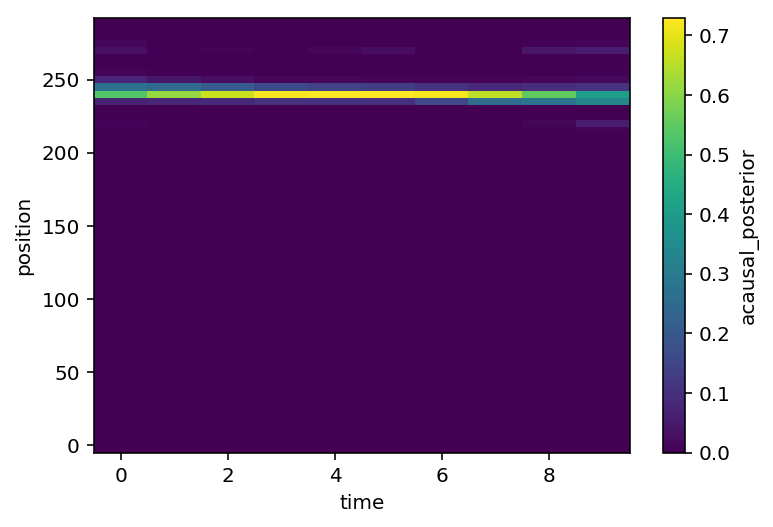

In [28]:
fig, ax = plt.subplots()
results.acausal_posterior.plot(x='time', y='position', ax=ax)